In [6]:
import os
import shutil
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

In [45]:
class PARAMS:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    noize_dim = 100
    num_epochs = 350
    lr = 2e-4
    batch_size = 128
    img_size = 64
    channels = 3

### В первую очередь сделаем считывание данных для модели

In [46]:
transform = transforms.Compose(
    [
        transforms.Resize((PARAMS.img_size,PARAMS.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(tuple((0.5 for i in range(PARAMS.channels))), tuple((0.5 for i in range(PARAMS.channels))))
    ]
)

In [47]:
dataset = datasets.ImageFolder(root='images', transform=transform)
dataloader = DataLoader(dataset, batch_size=PARAMS.batch_size, shuffle=True)

In [48]:
next(iter(dataloader))[0].shape

torch.Size([128, 3, 64, 64])

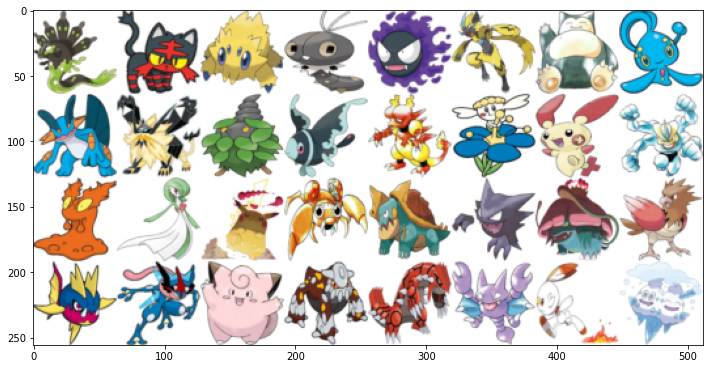

In [49]:
### Посмотрим примеры изображений, которые содержатся в данных
images = (next(iter(dataloader))[0][:32].detach().numpy()).reshape(4, 8,3, 64, 64)
images = np.concatenate(np.concatenate(images, axis=2), axis=2).transpose(1,2,0)*0.5+0.5
plt.figure(figsize=(12, 24))
plt.imshow(images)
plt.show()

### Для реализации ГАН будем использовать DCGAN

![Схема генератора из статьи](./generator_scheme.png)

In [50]:
### Часть сосздания свертки для дискриминатора
def discriminator_block(in_channels, out_channels, kernel, stride, padding):
    block =  nn.Sequential(
        nn.Conv2d(
            in_channels = in_channels,
            out_channels=out_channels,
            kernel_size=kernel,
            stride=stride,
            padding=padding,
            bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
    return block
### Часть создание развретки для генератора
def generator_block(in_channels, out_channels, kernel, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=kernel,
                           stride=stride,
                           padding=padding,
                           bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [51]:
### Дискриминатор
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2,2),
                padding=1
            ),
            nn.LeakyReLU(0.2),
            discriminator_block(128, 256, 4, 2, 1),
            discriminator_block(256, 512, 4, 2, 1),
            discriminator_block(512, 1024, 4, 2, 1),
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=(4,4), stride=(1,1), padding=0),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.discriminator(x)

### Генератор
class Generator(nn.Module):
    def __init__(self, channels, noize_dim):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            generator_block(in_channels=noize_dim, out_channels=1024, kernel=(4,4), stride=(1,1), padding=0),
            generator_block(in_channels=1024, out_channels=512, kernel=(4,4), stride=(2,2), padding=1),
            generator_block(in_channels=512, out_channels=256, kernel=(4,4), stride=(2,2), padding=1),
            generator_block(in_channels=256, out_channels=128, kernel=(4,4), stride=(2,2), padding=1),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=channels,
                               kernel_size=(4,4),
                               stride=(2,2),
                               padding=(1,1)),
            nn.Tanh()
        )
    def forward(self, x):
        return self.generator(x)

In [52]:
### Инициализация начального распределения параметров модели
def init_weights(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0, 0.02)

### Начнем тренировку нейронной сети

In [53]:
discriminator = Discriminator(channels=PARAMS.channels).to(PARAMS.device)
generator = Generator(channels=PARAMS.channels, noize_dim=PARAMS.noize_dim).to(PARAMS.device)
init_weights(generator)
init_weights(discriminator)

In [54]:
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = PARAMS.lr, betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(generator.parameters(), lr=PARAMS.lr, betas=(0.5, 0.999))

epoch 169, batch 10 of 20


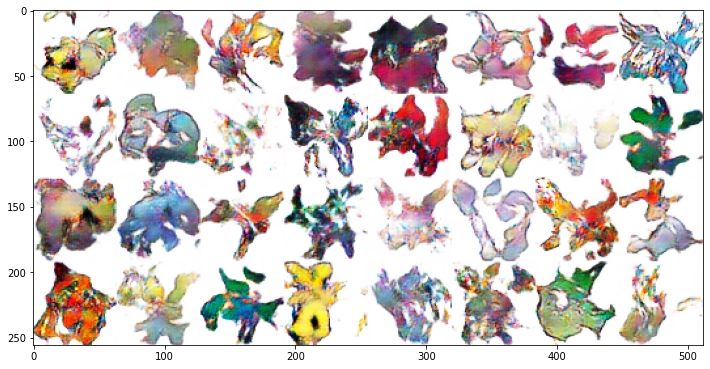

 48%|████▊     | 169/350 [1:17:46<1:23:17, 27.61s/it]


KeyboardInterrupt: 

In [55]:
default_noise = torch.randn(PARAMS.batch_size, PARAMS.noize_dim,1,1).to(PARAMS.device)
bceloss = nn.BCELoss()
for epoch in tqdm(range(PARAMS.num_epochs)):
    loss_gen = 0
    loss_disc = 0
    loss_gen = 0
    for batch_idx, (image, _) in enumerate(dataloader):
        image = image.to(PARAMS.device)
        d_real = discriminator(image).squeeze(-1)

        noise = torch.randn(PARAMS.batch_size, PARAMS.noize_dim, 1, 1).to(PARAMS.device)
        fake = generator.forward(noise)
        d_fake = discriminator.forward(fake).view(PARAMS.batch_size)

        # calculate loss function
        #discriminator
        loss_d = bceloss(d_real, torch.ones_like(d_real)) + bceloss(d_fake, torch.zeros_like(d_fake))
        loss_disc+=loss_d.detach().item()
        discriminator.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()

        #generator
        d_fake = discriminator.forward(fake).view(PARAMS.batch_size)
        loss_g = bceloss(d_fake, torch.ones_like(d_fake))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        loss_gen+=loss_g.detach().item()
        clear_output()
        # print(f'loss_gen={loss_gen/batch_size}, loss_disc={loss_disc/batch_size}')
        print(f'epoch {epoch}, batch {batch_idx} of {len(dataloader)}')

        images = (generator.forward(default_noise).reshape(PARAMS.batch_size, PARAMS.channels, PARAMS.img_size, PARAMS.img_size).cpu().detach().numpy())[:32].reshape(4, 8, 3, 64, 64)
        images = np.concatenate(np.concatenate(images, axis=2), axis=2).transpose(1, 2, 0) * 0.5 + 0.5
        plt.figure(figsize=(12, 24))
        plt.imshow(images)
        plt.show()

In [56]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

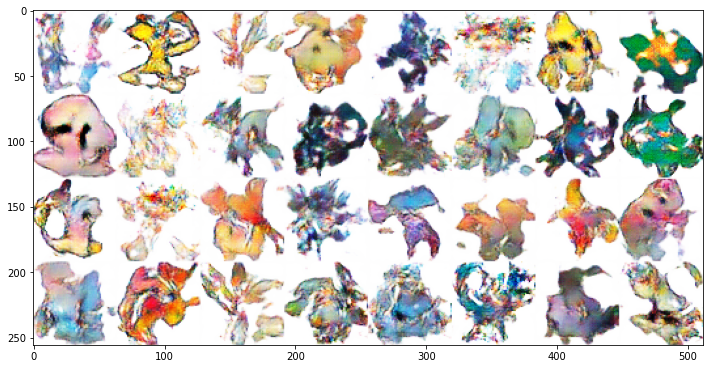

In [63]:
default_noise = torch.randn(PARAMS.batch_size, PARAMS.noize_dim,1,1).to(PARAMS.device)
images = (generator.forward(default_noise).reshape(PARAMS.batch_size, PARAMS.channels, PARAMS.img_size, PARAMS.img_size).cpu().detach().numpy())[:32].reshape(4, 8, 3, 64, 64)
images = np.concatenate(np.concatenate(images, axis=2), axis=2).transpose(1, 2, 0) * 0.5 + 0.5
plt.figure(figsize=(12, 24))
plt.imshow(images)
plt.show()

In [ ]:
### Пример загрузки моделей

In [64]:
discriminator2 = Discriminator(channels=PARAMS.channels).to(PARAMS.device)
generator2 = Generator(channels=PARAMS.channels, noize_dim=PARAMS.noize_dim).to(PARAMS.device)

In [66]:
discriminator2.load_state_dict(torch.load('discriminator.pth'), strict=False)
generator2.load_state_dict(torch.load('generator.pth'), strict=False)

<All keys matched successfully>

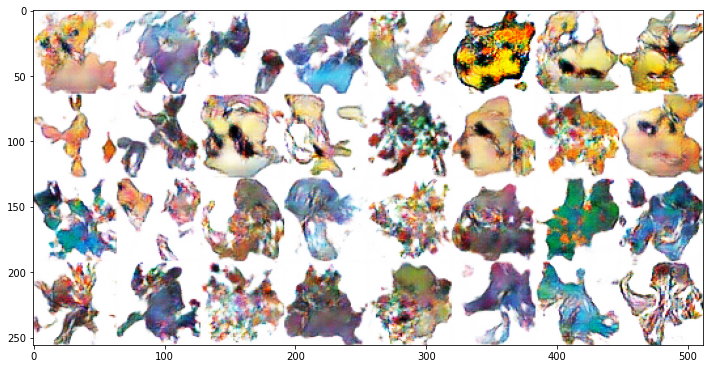

In [67]:
### Пример работы загруженной модели
default_noise = torch.randn(PARAMS.batch_size, PARAMS.noize_dim,1,1).to(PARAMS.device)
images = (generator2.forward(default_noise).reshape(PARAMS.batch_size, PARAMS.channels, PARAMS.img_size, PARAMS.img_size).cpu().detach().numpy())[:32].reshape(4, 8, 3, 64, 64)
images = np.concatenate(np.concatenate(images, axis=2), axis=2).transpose(1, 2, 0) * 0.5 + 0.5
plt.figure(figsize=(12, 24))
plt.imshow(images)
plt.show()